# Predicting non-performing loans

## Overview

- Binary classification problem.
- Loan performance feature highly assymetric.
- Approach is to keep it simple. A baseline model for more advanced modeling.
- When filtering features, it is assumed that the prediction is made before issueing the loan and is not updated in the future.
- Some features that could be useful but either would take too much time to process or would slow down the model too much are dropped.

## Environment setup

In [51]:
! pip install pandas matplotlib scikit-learn xgboost seaborn

In [141]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", 200)


In [53]:
fpath = "C:/Users/davis/OneDrive/Documents/Case_study_and_LoanStats_2018Q2/LoanStats_2018Q2.csv"
raw_data = pd.read_csv(fpath, skiprows=1, low_memory=False)

raw_data.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,12000.0,12000.0,12000.0,60 months,20.39%,320.54,D,D4,Garage Man,10+ years,RENT,42000.0,Verified,Jun-2018,Current,n,NaN,NaN,credit_card,Credit card refinancing,440xx,OH,14.46,0.0,Nov-2007,1.0,NaN,NaN,4.0,0.0,8090.0,64.7%,9.0,w,11269.75,11269.75,1896.05,1896.05,730.25,1165.80,0.0,0.0,0.0,Jan-2019,320.54,Feb-2019,Jan-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,11968.0,1.0,1.0,0.0,1.0,24.0,3878.0,33.0,3.0,3.0,5445.0,50.0,12500.0,1.0,0.0,1.0,4.0,2992.0,4410.0,64.7,0.0,0.0,125.0,127.0,3.0,3.0,0.0,3.0,NaN,3.0,NaN,0.0,3.0,3.0,3.0,4.0,4.0,3.0,5.0,3.0,4.0,0.0,0.0,0.0,3.0,100.0,66.7,0.0,0.0,24138.0,11968.0,12500.0,11638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,29150.0,29150.0,29150.0,60 months,20.39%,778.64,D,D4,Police Officer,10+ years,MORTGAGE,51000.0,Verified,Jun-2018,Current,n,NaN,NaN,home_improvement,Home improvement,807xx,CO,20.82,0.0,Feb-2003,1.0,49.0,NaN,11.0,0.0,12760.0,40.4%,34.0,w,27376.13,27376.13,4605.80,4605.80,1773.87,2831.93,0.0,0.0,0.0,Jan-2019,778.64,Feb-2019,Jan-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,177088.0,2.0,1.0,0.0,3.0,13.0,18790.0,83.0,3.0,3.0,3052.0,58.0,31600.0,0.0,0.0,2.0,7.0,16099.0,16854.0,39.6,0.0,0.0,184.0,176.0,1.0,1.0,4.0,1.0,NaN,3.0,NaN,0.0,7.0,8.0,8.0,12.0,15.0,9.0,15.0,8.0,11.0,0.0,0.0,0.0,4.0,97.1,37.5,0.0,0.0,201814.0,31550.0,27900.0,22714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,8000.0,8000.0,8000.0,36 months,13.06%,269.79,C,C1,Manager,10+ years,MORTGAGE,73000.0,Source Verified,Jun-2018,Current,n,NaN,NaN,other,O

## Data cleanup

Just from the first few rows above, we can observe that the data is messy. There are:

- Missing values
- Text and symbols in cells containing numeric values
- Dates as strings
- ...

The cleanup steps include:

- Remove duplicates and deal with completely missing data
- Decide what to do with IDs
- Deal with mostly missing data (if still a lot of data missing)
- Categorize unknown data types
- Develop a data transformer/encoder for each data type
- Combine transformers/encoders in a pipeline

### Remove duplicates and deal with completely missing data

In [54]:
# Make a copy so we don't modify the original data
data = raw_data.copy()


In [55]:
orig_shape = raw_data.shape
orig_size = raw_data.size
miss_pct = raw_data.isna().sum().sum() / data.size * 100

print("Shape of the dataset:", orig_shape)
print("Size of the dataset:", orig_size)
print("Percent of values missing: %.2f" % miss_pct)


Shape of the dataset: (130774, 145)
Size of the dataset: 18962230
Percent of values missing: 27.97


In [56]:
data = data.drop_duplicates()
print("%d duplicate rows removed." % (orig_shape[0] - data.shape[0]))

data = data.dropna(axis=0, how="all")
print("%d rows containing only nan values removed." % (orig_shape[0] - data.shape[0]))

data = data.dropna(axis=1, how="all")
print(
    "%d columns containing only nan values removed." % (orig_shape[1] - data.shape[1])
)

new_miss_pct = data.isna().sum().sum() / data.size * 100
print("\nNew shape of the dataset:", data.shape)
print("New size of the dataset:", data.size)
print("New percent of values missing: %.2f" % new_miss_pct)


0 duplicate rows removed.
0 rows containing only nan values removed.
3 columns containing only nan values removed.

New shape of the dataset: (130774, 142)
New size of the dataset: 18569908
New percent of values missing: 26.45


### Drop IDs

Because I mentioned that my strategy is to preserve as much information as possible, this action needs further clarification.

There can be all kind of IDs. For example:

- A simple index just to assign a unique identifier
- An encrypted key (e.g. a hash key)
- A key encoding and condensing useful information

As such, it does not automatically mean that any ID should be dropped. In this case however it is pretty simple as the ID is not really an ID. It contains only two entries, each being an aggregate value of the total sum funded per policy code.


In [57]:
data.loc[~data["id"].isna()]


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
130772,Total amount funded in policy code 1: 2080429200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130773,Total amount funded in policy code 2: 737901574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now we can just note the 2 values and remove ID information.

Total amount funded in policy code 1: 2080429200

Total amount funded in policy code 2: 737901574

In [58]:
# Extra note: funded_amnt values only for policy code 1
n_pol_code1 = data["funded_amnt"][data["policy_code"] == 1].count()
n_pol_code_notna = data["funded_amnt"][~data["funded_amnt"].isna()].count()

# Extra note 2: sum of funded_amnt for policy code 1 sums up to the value
# mentioned in the id column
data["funded_amnt"][data["policy_code"] == 1].sum()


2080429200.0

In [59]:
data = data.loc[data["id"].isna()]
data = data.drop(axis=1, labels=["id"])

new_miss_pct = data.isna().sum().sum() / data.size * 100
print("\nNew shape of the dataset:", data.shape)
print("New size of the dataset:", data.size)
print("New percent of values missing: %.2f" % new_miss_pct)



New shape of the dataset: (130772, 141)
New size of the dataset: 18438852
New percent of values missing: 25.93


After removing what can be removed without losing information, the dataset is still missing almost 26% of values!
This means that there are multiple parameters with just a few values.

Although further analysis and detailed handling of these parameters could improve the final model performance, the time cost of doing this is not worth it for this assignment.

Hence, any parameter with more than 75% of values missing will be dropped.

In [60]:
for cat in data.columns:
    n_miss = data[cat].isna().sum()
    n_all = data[cat].size
    pct_miss = n_miss / n_all * 100
    if pct_miss > 75:
        data = data.drop(cat, axis=1)

new_miss_pct = data.isna().sum().sum() / data.size * 100
print("\nNew shape of the dataset:", data.shape)
print("New size of the dataset:", data.size)
print("New percent of values missing: %.2f" % new_miss_pct)



New shape of the dataset: (130772, 104)
New size of the dataset: 13600288
New percent of values missing: 1.90


Now we have less than 2% of values missing, which is much better. The rest of missing values will be dealt with later on.

### Categorize unknown data types

First thing's first, let's isolate the parameter that we are trying to estimate.

In [61]:
y = data["loan_status"]

if "loan_status" in data.columns:
    data = data.drop("loan_status", axis=1)


In [62]:
data.dtypes.value_counts()


float64    79
object     24
Name: count, dtype: int64

In [63]:
# TODO: Update text below


We can observe that there are 79 columns containing float values and 24 object columns.
The object is just a generic type assigned when a column does not match a more specific type.

We already know from looking at the first few rows earlier that there definitely are numeric values with text that would result in an object data type but should be a float or int. 

Hence, we need to go over these object columns and try to make sense of them. My approach here is to first cluster similar data types into groups.

This way we could possibly come up with a pipeline that could process each cluster using a single algorithm instead of manually process each one individually.

The data columns were categorized as:

- **Dates**
- **Numerical**: Floating point or integer values labeled as strings
- **Ordinal**: Categorical parameters that can be ranked/sorted
- **Nominal**: Categorical parameters with no numerical relationship
- **Ignore**: Leakage, dimensionality too high, confusing parameter, etc.


In [64]:
object_set = set(data.dtypes[data.dtypes == "object"].index)
object_set


{'addr_state',
 'application_type',
 'debt_settlement_flag',
 'disbursement_method',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'next_pymnt_d',
 'purpose',
 'pymnt_plan',
 'revol_util',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code'}

In [65]:
ignore_set = set(
    [
        "pymnt_plan",  # all but two values are the same
        "debt_settlement_flag",  # potential leakage
        "hardship_flag",  # potential leakage
        "emp_title",  # very high dimensionality (too much work to clean up)
        "zip_code",  # # very high dimensionality (too much work to clean up)
        "title",  # same information as 'purpose' parameter
        "next_pymnt_d",  # information not relevant for model
        "addr_state",  # too many options (can deal with this later)
    ]
)


In [66]:
# Object data types that should be dates
# Column names containing _d or date
date_subset = [
    name
    for name in data.dtypes[data.dtypes == "object"].index
    if ("_d" in name or "date" in name) and name not in ignore_set
]
date_set = set(date_subset + ["earliest_cr_line"])


In [67]:
numerical_set = set(
    [
        "emp_length",
        "term",
        "revol_util",
        "int_rate",
    ]
)


In [68]:
ordinal_set = set(
    [
        "grade",
        "sub_grade",
    ]
)


In [69]:
nominal_set = set(
    [
        "home_ownership",
        "verification_status",
        "purpose",
        "application_type",  # binary, but basically useless if other joint stuff is dropped
        "initial_list_status",  # binary
        "disbursement_method",  # binary
    ]
)


In [70]:
# NOTE: JOINT APPLICATION DATA IS DISCARDED
(object_set - date_set - numerical_set - ordinal_set - nominal_set - ignore_set)


set()

### Develop a data transformer/encoder for each data type

#### Date transformer

Dates require special attention as e.g. months and hours are cyclic variables. 

In this case all dates are in the format Mon-YYYY.

In [71]:
"""
The approach here is to:

1. Separate month and year
2. Map the 3 character string version of the month to a number in the range 1-12
3. Calculate sin and cos for the numerical month number (this accounts for cycles)
4. Create in total 3 new columns - month_cos, month_sin, year
5. Drop old column
"""


class CustomDateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, date_cats):
        self.date_cats = date_cats
        self.new_cols = None

    def fit(self, X, y=None):
        return self

    def _month_str_to_num(self, mstr):
        mapping = {
            "jan": 1,
            "feb": 2,
            "mar": 3,
            "apr": 4,
            "may": 5,
            "jun": 6,
            "jul": 7,
            "aug": 8,
            "sep": 9,
            "oct": 10,
            "nov": 11,
            "dec": 12,
        }

        return mapping[mstr]

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        for cat in self.date_cats:
            months = X[cat].str.lower().str.extract(r"([a-z]+)", expand=False)
            months[~months.isna()] = months[~months.isna()].apply(
                self._month_str_to_num
            )
            months = pd.to_numeric(months, downcast="integer")

            years = X[cat].str.extract(r"(\d+)", expand=False)
            years = pd.to_numeric(years, downcast="integer")

            month_sin = np.reshape(np.sin((months - 1) * (2.0 * np.pi / 12)), (-1, 1))
            month_cos = np.reshape(np.cos((months - 1) * (2.0 * np.pi / 12)), (-1, 1))

            month_sin_name = f"{cat}_month_sin"
            month_cos_name = f"{cat}_month_cos"
            year_name = f"{cat}_year"

            X[month_sin_name] = month_sin
            X[month_cos_name] = month_cos
            X[year_name] = years

        X = X.drop(labels=self.date_cats, axis=1)

        self.new_cols = X.columns

        return X

    def get_feature_names_out(self, inp: list) -> list:
        return self.new_cols


#### Numerical transformer

In [72]:
class NumericTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        if "emp_length" in X.columns:
            # Replace employment length less than 1 year with 0
            X["emp_length"] = X["emp_length"].str.replace("< 1 year", "0")

        # Regular expression for extracting floating point and integer values
        # Handles both positive and negative numbers
        # Also make sure the extracted values are of numeric data type

        for col_name in X.columns:
            # There are only a few columns, so the for loop isn't that bad
            X[col_name] = X[col_name].str.extract(r"(-?[.\d]+)")

        X = X.apply(pd.to_numeric)

        return X

    def get_feature_names_out(self, inp: list) -> list:
        return inp


#### Drop ignore parameters

In [74]:
for label in list(ignore_set):
    try:
        data = data.drop(labels=label, axis=1)
    except:
        # Avoids errors in case the cell is run twice
        pass


### Pipeline all the transformation steps

In [75]:
date_cols = list(date_set)
num_cols = list(numerical_set)
ord_cols = list(ordinal_set)
nom_cols = list(nominal_set)


In [76]:
date_pipe = Pipeline(
    steps=[
        ("fix_dates", CustomDateEncoder(date_cols)),
    ]
)


In [77]:
num_pipe = Pipeline(
    steps=[
        ("fix_dtypes", NumericTransformer()),
    ]
)


In [78]:
ord_pipe = Pipeline(
    steps=[
        ("yeah", OrdinalEncoder()),
    ]
)


In [79]:
nom_pipe = Pipeline(
    steps=[
        ("haha", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)


In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ("date", date_pipe, date_cols),
        ("num", num_pipe, num_cols),
        ("ord", ord_pipe, ord_cols),
        ("nom", nom_pipe, nom_cols),
    ]
)


## Modeling

In [85]:
fixed_data = preprocessor.fit_transform(data)
new_cols = preprocessor.get_feature_names_out(data.columns)
X = pd.DataFrame(fixed_data, columns=new_cols)


c:\Users\davis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [88]:
y = y.map(
    {
        "Current": 0,
        "Fully Paid": 0,
        "In Grace Period": 0,
        "Late (16-30 days)": 1,
        "Late (31-120 days)": 1,
        "Charged Off": 1,
        "Default": 1,
    },
)

y.value_counts()


loan_status
0    125888
1      4884
Name: count, dtype: int64

### Random Forests

In [114]:
from sklearn.model_selection import train_test_split

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=0,
    stratify=y,
)


In [116]:
from sklearn.ensemble import RandomForestClassifier

yeah_pipe = Pipeline(
    steps=[
        ("imp", SimpleImputer()),
        (
            "clasif",
            RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0),
        ),
    ]
)


In [124]:
from sklearn.metrics import get_scorer_names

get_scorer_names()[0:40]


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted']

In [117]:
from sklearn.model_selection import cross_val_score, cross_validate

# Multiply by -1 since sklearn calculates *negative* MAE
scores = cross_validate(yeah_pipe, X, y, cv=5, scoring=["recall", "precision", "f1"])

scores


{'fit_time': array([58.04965425, 57.07639503, 55.72057414, 58.18728638, 49.65949106]),
 'score_time': array([1.76654434, 1.59712505, 1.61169124, 1.54156423, 1.56581235]),
 'test_recall': array([0.48004094, 0.54657114, 0.55532787, 0.5087001 , 0.52712385]),
 'test_precision': array([0.81565217, 0.77391304, 0.72266667, 0.7019774 , 0.67408377]),
 'test_f1': array([0.60438144, 0.64067187, 0.62804171, 0.58991098, 0.59161401])}

### Boosted Random Forests

[0]	validation_0-logloss:0.45612	validation_1-logloss:0.45414
[37]	validation_0-logloss:0.05089	validation_1-logloss:0.06101
[0]	validation_0-logloss:0.45596	validation_1-logloss:0.45399
[42]	validation_0-logloss:0.04945	validation_1-logloss:0.05736
[0]	validation_0-logloss:0.45546	validation_1-logloss:0.45649
[38]	validation_0-logloss:0.04867	validation_1-logloss:0.06711
[0]	validation_0-logloss:0.45502	validation_1-logloss:0.45684
[47]	validation_0-logloss:0.04712	validation_1-logloss:0.06419
[0]	validation_0-logloss:0.45458	validation_1-logloss:0.45715
[41]	validation_0-logloss:0.04774	validation_1-logloss:0.06784


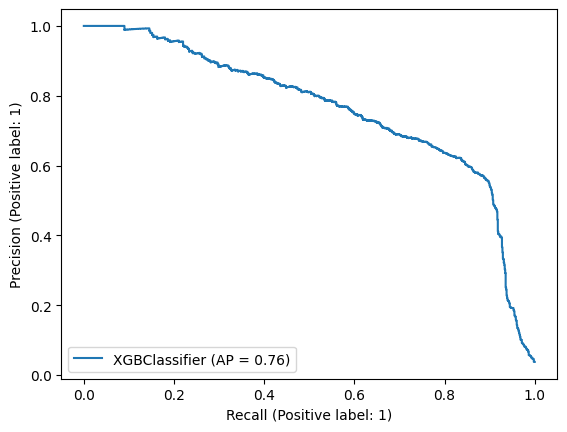

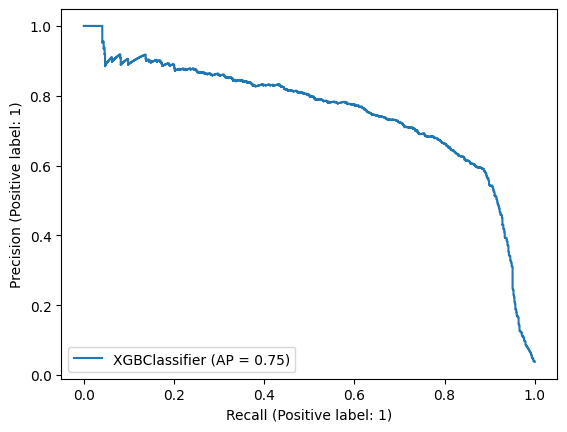

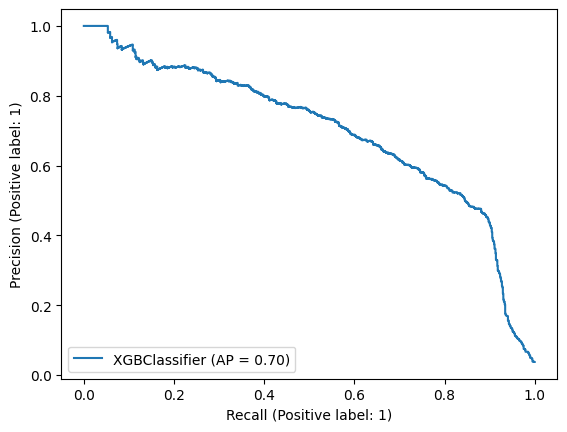

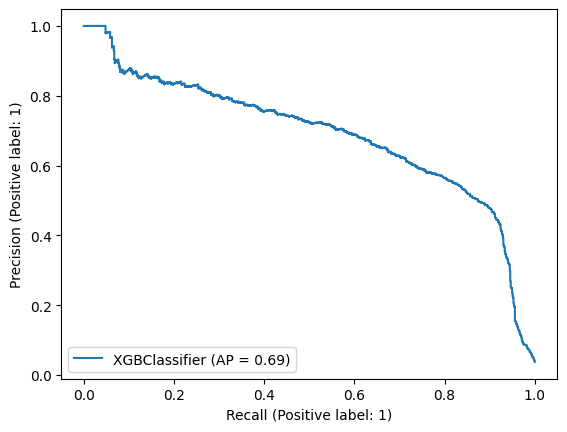

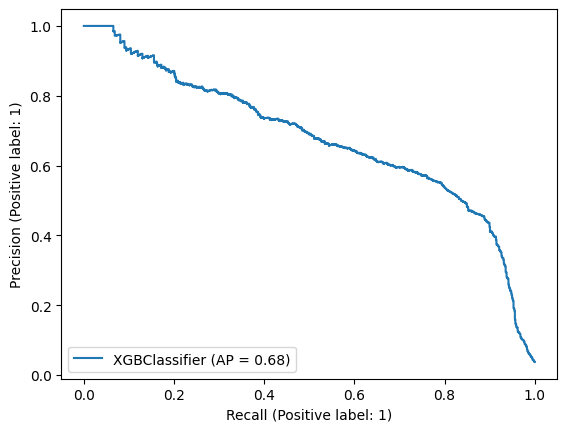

In [139]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import PrecisionRecallDisplay


sgkf = StratifiedKFold()

for i, (train_idx, valid_idx) in enumerate(sgkf.split(X, y)):
    X_train = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]

    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    # Imputation
    imp = SimpleImputer()
    imp_X_train = pd.DataFrame(imp.fit_transform(X_train))
    imp_X_valid = pd.DataFrame(imp.transform(X_valid))

    # Imputation removed column names; put them back
    imp_X_train.columns = X_train.columns
    imp_X_valid.columns = X_valid.columns

    bst = XGBClassifier(n_estimators=1000, early_stopping_rounds=20)

    bst.fit(
        imp_X_train,
        y_train,
        eval_set=[(imp_X_train, y_train), (imp_X_valid, y_valid)],
        verbose=50,
    )

    PrecisionRecallDisplay.from_estimator(
        bst, imp_X_valid, y_valid, name="XGBClassifier"
    )
